In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from itertools import combinations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import shap

In [83]:
df = pd.read_csv('/Users/suhrudp/Library/CloudStorage/OneDrive-Personal/Stats/RPN/TBI ML/df.csv')

df = df.dropna()

In [84]:
column_names_with_indices = list(enumerate(df.columns))
for index, col_name in column_names_with_indices:
    print(f"Index: {index}, Column Name: {col_name}")

Index: 0, Column Name: age
Index: 1, Column Name: sex
Index: 2, Column Name: time_to_first_doctor
Index: 3, Column Name: time_in_trauma_center
Index: 4, Column Name: mechanism_of_injury
Index: 5, Column Name: headache
Index: 6, Column Name: seizures
Index: 7, Column Name: vomiting
Index: 8, Column Name: amnesia
Index: 9, Column Name: csf_rhinorrhea
Index: 10, Column Name: alcohol_consumption
Index: 11, Column Name: pulse
Index: 12, Column Name: respiration
Index: 13, Column Name: speech
Index: 14, Column Name: speech_past_history
Index: 15, Column Name: pre_existing_neurological_deficiency
Index: 16, Column Name: head_injury_type
Index: 17, Column Name: associated_injury
Index: 18, Column Name: gcs_evm
Index: 19, Column Name: gcs_e
Index: 20, Column Name: gcs_v
Index: 21, Column Name: gcs_m
Index: 22, Column Name: right_eye_vision
Index: 23, Column Name: right_eye_temporal_loss
Index: 24, Column Name: right_eye_nasal_loss
Index: 25, Column Name: left_eye_vision
Index: 26, Column Name: 

In [85]:
X = df.iloc[:, 0:37].drop(df.columns[[19, 20, 21, 33]], axis=1)

y = df.iloc[:,40]

In [86]:
Counter(y)

Counter({0: 1812, 1: 161})

In [87]:
all_mappings = {
    'mechanism_of_injury': {
        'Games': 0, 'Fall from Height': 1, 'Machine Injury': 2, 'Road Traffic Acident': 3,
        'Assault': 4, 'GunShot': 5, 'Others': 6
    },
    'respiration': {
        'Normal': 0, 'Periodic': 1, 'Cheyne Strok': 2, 'Gasping': 3
    },
    'xray_abnormality': {
        'Normal': 0, 'Listhesis': 1, 'Fracture': 2
    },
    'right_eye_vision': {
        'Absent':4, 'Projection of light': 3, 'Finger counting 1 - 3 ft': 2, 'Finger counting 3 - 6 ft': 1, 'Finger counting > 6 ft': 0
    },
    'left_eye_vision': {
        'Absent': 5, 'Projection of light': 4, 'Finger counting 1 - 3 ft': 2, 'Finger counting 3 - 6 ft': 1, 'Finger counting > 6 ft': 0,  'Finger counting < 1 ft': 3
    },
    'associated_injury': {
        'No Injury': 0, 'Other': 1, 'Long Bone': 2, 'Pelvic Injury': 3, 'Chest Injury': 4, 'SIG Facial Fracture': 5
    },
    'speech': {
        'Normal': 0, 'Dysphasia': 1, 'Aphasia': 2, 'CanNot Assess': 3
    },
    'sex': {
        'Female ': 0, 'Male': 1
    },
    'headache': {
        'No': 0, 'Yes': 1
    },
    'seizures': {
        'No': 0, 'Yes': 1
    },
    'vomiting': {
        'No': 0, 'Yes': 1
    },
    'amnesia': {
        'No': 0, 'Yes': 1
    },
    'csf_rhinorrhea': {
        'No': 0, 'Yes': 1
    },
    'alcohol_consumption': {
        'Absent': 0, 'Present': 1
    },
    'speech_past_history': {
        'No': 0, 'Yes': 1
    },
    'pre_existing_neurological_deficiency': {
        'No': 0, 'Yes': 1
    },
    'head_injury_type': {
        'Closed': 0, 'Open': 1
    },
    'right_eye_temporal_loss': {
        'No': 0, 'Yes': 1
    },
    'right_eye_nasal_loss': {
        'No': 0, 'N': 0, 'Yes': 1
    },
    'left_eye_temporal_loss': {
        'No': 0, 'Yes': 1
    },
    'left_eye_nasal_loss': {
        'No': 0, 'Yes': 1
    },
    'vision_past_history': {
        'No': 0
    },
    'power_rul': {
        '0 power': 0, '1 power': 1, '2 power': 2, '3 power': 3, '4 power': 4, '5 power': 5
    },
    'power_rll': {
        '0 power': 0, '1 power': 1, '2 power': 2, '3 power': 3, '4 power': 4, '5 power': 5
    },
    'power_lul': {
        '0 power': 0, '1 power': 1, '2 power': 2, '3 power': 3, '4 power': 4, '5 power': 5
    },
    'power_lll': {
        '0 power': 0, '1 power': 1, '2 power': 2, '3 power': 3, '4 power': 4, '5 power': 5
    }
}

encoding_mappings = {}
for column, mapping in all_mappings.items():
    unmapped_values = X[~X[column].isin(mapping.keys())][column].unique()
    if len(unmapped_values) > 0:
        print(f"Warning: Unmapped values found in '{column}': {unmapped_values}")

    X[column] = X[column].map(mapping).fillna(-1)
    encoding_mappings[column] = mapping

pd.set_option('display.max_columns', None)

print("Encoded DataFrame:")
print(X)

print("\nEncoding Mappings:")
for column, mapping in encoding_mappings.items():
    print(f"Column: {column}")
    print(mapping)
    print("-----------------------------")

Encoded DataFrame:
      age  sex  time_to_first_doctor  time_in_trauma_center  \
0      13    1                   1.0                    3.0   
1      19    1                   1.0                    6.0   
2      20    1                   1.0                    5.0   
3      35    1                   1.0                    3.0   
4      11    1                   1.0                    8.0   
...   ...  ...                   ...                    ...   
2165   40    0                   1.0                   48.0   
2166   28    0                   2.0                    4.0   
2167   60    1                   2.0                    4.0   
2168   32    1                  20.0                   20.0   
2169   35    1                   2.0                    8.0   

      mechanism_of_injury  headache  seizures  vomiting  amnesia  \
0                       4         1         0         1        0   
1                       3         1         0         0        0   
2                   

In [88]:
ros = KMeansSMOTE(random_state=2, cluster_balance_threshold=0.1)

X_resampled, y_resampled = ros.fit_resample(X, y)

print(f"Resampled dataset shape: {Counter(y_resampled)}")

Resampled dataset shape: Counter({1: 1813, 0: 1812})


In [89]:
le = LabelEncoder()

le.fit(y_resampled)

y_encoded = le.transform(y_resampled) 

print("\nFirst 10 original labels:")
print(y[:15])
print("\nFirst 10 encoded labels:")
print(y_encoded[:15])

y_encoded = pd.DataFrame(y_encoded)


First 10 original labels:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
Name: patient_condition_encoded, dtype: int64

First 10 encoded labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [90]:
mapping_data = []
for column, mapping in encoding_mappings.items():
    for original_value, encoded_value in mapping.items():
        mapping_data.append({
            'Column': column,
            'Original Value': original_value,
            'Encoded Value': encoded_value
        })

mapping_df = pd.DataFrame(mapping_data)

mapping_df.to_csv("encoding_mappings_surv.csv", index=False)

print("Mappings have been saved to 'encoding_mappings_surv.csv'.")

Mappings have been saved to 'encoding_mappings_surv.csv'.


In [91]:
X_resampled = X_resampled.sample(frac=1, random_state=2).reset_index(drop=True)
y_encoded = y_encoded.sample(frac=1, random_state=2).reset_index(drop=True)

new_columns = X_resampled.columns.to_series().sample(frac=1, random_state=2)
X_resampled = X_resampled[new_columns]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=2)

In [93]:
scaler = RobustScaler()

train_columns = X_train.columns
train_index = X_train.index
test_columns = X_test.columns
test_index = X_test.index

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(data=X_train, columns=train_columns, index=train_index)
X_test = pd.DataFrame(data=X_test, columns=test_columns, index=test_index)

In [94]:
X3_train = X_train

In [95]:
X1_test = X_test

In [49]:
metrics = {
    "Accuracy": accuracy_score,
    "Precision/PPV": lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'),
    "NPV": lambda y_true, y_pred: npv(confusion_matrix(y_true, y_pred)),
    "Recall /Sensitivity": lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary'),
    "Specificity": lambda y_true, y_pred: specificity(confusion_matrix(y_true, y_pred)),
    "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    "AUC-ROC": lambda y_true, y_prob: roc_auc_score(y_true, y_prob)
}

def specificity(conf_matrix):
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    return TN / (TN + FP)

def npv(conf_matrix):
    TN = conf_matrix[0, 0]
    FN = conf_matrix[1, 0]
    return TN / (TN + FN)

In [50]:
def bootstrap_ci(y_true, y_pred, y_pred_proba, metric_func, n_bootstrap=2000, alpha=0.05):
    bootstrap_estimates = []

    y_true = y_true.values if isinstance(y_true, (pd.DataFrame, pd.Series)) else y_true
    y_pred = y_pred.values if isinstance(y_pred, (pd.DataFrame, pd.Series)) else y_pred
    if y_pred_proba is not None:
        y_pred_proba = y_pred_proba.values if isinstance(y_pred_proba, (pd.DataFrame, pd.Series)) else y_pred_proba

    for _ in range(n_bootstrap):
        indices = np.random.choice(len(y_true), size=len(y_true), replace=True)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        
        if y_pred_proba is not None:
            y_pred_proba_sample = y_pred_proba[indices]
            estimate = metric_func(y_true_sample, y_pred_proba_sample)
        else:
            estimate = metric_func(y_true_sample, y_pred_sample)
        bootstrap_estimates.append(estimate)
    
    sorted_estimates = np.sort(bootstrap_estimates)
    lower = np.percentile(sorted_estimates, 100 * alpha / 2.)
    upper = np.percentile(sorted_estimates, 100 * (1 - alpha / 2.))
    return lower, upper

In [51]:
clflogreg = LogisticRegression(multi_class='ovr')
clflogreg.fit(X3_train, y_train)

clfsvm = svm.SVC(kernel='linear', probability=True)
clfsvm.fit(X3_train, y_train)

clfrfc = RandomForestClassifier(random_state=2)
clfrfc.fit(X3_train, y_train)

clfxgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=2)
clfxgb.fit(X3_train, y_train)

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=2, ...)

In [53]:
classifiers = {
    'Logistic Regression': clflogreg,
    'SVM': clfsvm,
    'Random Forest': clfrfc,
    'XGBoost': clfxgb
}

for clf_name, clf in classifiers.items():
    print(f"\nResults for {clf_name}:\n")

    y_pred = clf.predict(X1_test)

    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X1_test)[:, 1]
    else:
        y_score = None

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n{conf_matrix}")

    for name, func in metrics.items():
        if name == "AUC-ROC":
            if y_score is not None:
                point_estimate = func(y_test, y_score)
                lower, upper = bootstrap_ci(y_test, y_pred, y_score, func)
                print(f"{name}: {point_estimate:.4f} [95% CI: {lower:.4f}, {upper:.4f}]")
        else:
            point_estimate = func(y_test, y_pred)
            lower, upper = bootstrap_ci(y_test, y_pred, None, func)
            print(f"{name}: {point_estimate:.4f} [95% CI: {lower:.4f}, {upper:.4f}]")


Results for Logistic Regression:

Confusion Matrix: 
[[468  76]
 [ 48 496]]
Accuracy: 0.8860 [95% CI: 0.8667, 0.9035]
Precision/PPV: 0.8671 [95% CI: 0.8381, 0.8938]
NPV: 0.9070 [95% CI: 0.8813, 0.9303]
Recall /Sensitivity: 0.9118 [95% CI: 0.8877, 0.9342]
Specificity: 0.8603 [95% CI: 0.8306, 0.8889]
F1 Score: 0.8889 [95% CI: 0.8687, 0.9083]
AUC-ROC: 0.9419 [95% CI: 0.9271, 0.9554]

Results for SVM:

Confusion Matrix: 
[[477  67]
 [ 44 500]]
Accuracy: 0.8980 [95% CI: 0.8796, 0.9154]
Precision/PPV: 0.8818 [95% CI: 0.8551, 0.9089]
NPV: 0.9155 [95% CI: 0.8916, 0.9387]
Recall /Sensitivity: 0.9191 [95% CI: 0.8950, 0.9414]
Specificity: 0.8768 [95% CI: 0.8481, 0.9037]
F1 Score: 0.9001 [95% CI: 0.8807, 0.9180]
AUC-ROC: 0.9429 [95% CI: 0.9274, 0.9576]

Results for Random Forest:

Confusion Matrix: 
[[532  12]
 [ 42 502]]
Accuracy: 0.9504 [95% CI: 0.9357, 0.9632]
Precision/PPV: 0.9767 [95% CI: 0.9623, 0.9891]
NPV: 0.9268 [95% CI: 0.9042, 0.9477]
Recall /Sensitivity: 0.9228 [95% CI: 0.9000, 0.9450

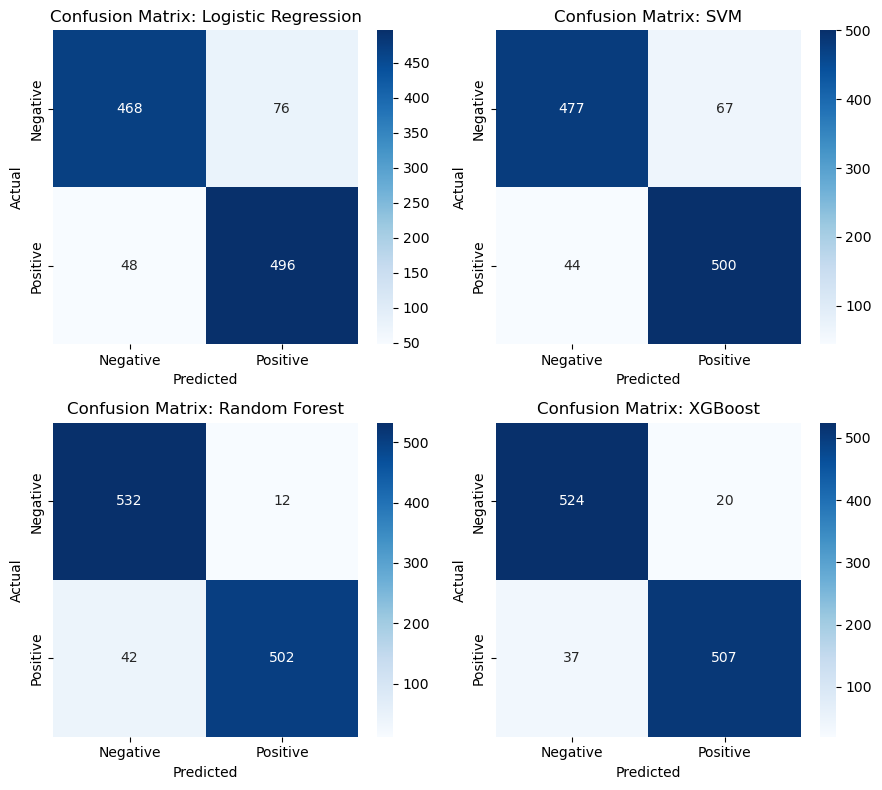

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrices = {}

for clf_name, clf in classifiers.items():
    y_pred = clf.predict(X1_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices[clf_name] = conf_matrix

fig, axes = plt.subplots(2, 2, figsize=(9, 8))
axes = axes.flatten()

for i, (clf_name, conf_matrix) in enumerate(conf_matrices.items()):
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=['Negative', 'Positive'], 
        yticklabels=['Negative', 'Positive'], 
        ax=axes[i]
    )
    axes[i].set_title(f'Confusion Matrix: {clf_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('confmat_survival_oversamp.png', dpi=900)
plt.show()

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

results = []

for clf_name, clf in classifiers.items():
    print(f"\nResults for {clf_name}:\n")

    y_pred = clf.predict(X1_test)

    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X1_test)[:, 1]
    else:
        y_score = None

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n{conf_matrix}")

    for name, func in metrics.items():
        if name == "AUC-ROC":
            if y_score is not None:
                point_estimate = func(y_test, y_score)
                lower, upper = bootstrap_ci(y_test, y_pred, y_score, func)
                print(f"{name}: {point_estimate:.4f} [95% CI: {lower:.4f}, {upper:.4f}]")
        else:
            point_estimate = func(y_test, y_pred)
            lower, upper = bootstrap_ci(y_test, y_pred, None, func)
            print(f"{name}: {point_estimate:.4f} [95% CI: {lower:.4f}, {upper:.4f}]")

        results.append({
            "Model": clf_name,
            "Metric": name,
            "Score": point_estimate,
            "Lower CI": lower,
            "Upper CI": upper
        })

results_df = pd.DataFrame(results)



Results for Logistic Regression:

Confusion Matrix: 
[[468  76]
 [ 48 496]]
Accuracy: 0.8860 [95% CI: 0.8667, 0.9053]
Precision/PPV: 0.8671 [95% CI: 0.8380, 0.8939]
NPV: 0.9070 [95% CI: 0.8806, 0.9307]
Recall /Sensitivity: 0.9118 [95% CI: 0.8873, 0.9345]
Specificity: 0.8603 [95% CI: 0.8299, 0.8876]
F1 Score: 0.8889 [95% CI: 0.8693, 0.9078]
AUC-ROC: 0.9419 [95% CI: 0.9280, 0.9562]

Results for SVM:

Confusion Matrix: 
[[477  67]
 [ 44 500]]
Accuracy: 0.8980 [95% CI: 0.8796, 0.9155]
Precision/PPV: 0.8818 [95% CI: 0.8536, 0.9069]
NPV: 0.9155 [95% CI: 0.8916, 0.9397]
Recall /Sensitivity: 0.9191 [95% CI: 0.8956, 0.9407]
Specificity: 0.8768 [95% CI: 0.8495, 0.9051]
F1 Score: 0.9001 [95% CI: 0.8807, 0.9172]
AUC-ROC: 0.9429 [95% CI: 0.9267, 0.9578]

Results for Random Forest:

Confusion Matrix: 
[[532  12]
 [ 42 502]]
Accuracy: 0.9504 [95% CI: 0.9375, 0.9623]
Precision/PPV: 0.9767 [95% CI: 0.9633, 0.9886]
NPV: 0.9268 [95% CI: 0.9056, 0.9475]
Recall /Sensitivity: 0.9228 [95% CI: 0.9000, 0.9442

In [56]:
results_df['Formatted Score'] = results_df.apply(
    lambda row: f"{row['Score']:.2f} [{row['Lower CI']:.2f}, {row['Upper CI']:.2f}]", axis=1
)

results_pivot_ci = results_df.pivot(index='Model', columns='Metric', values='Formatted Score')

csv_path = 'performance_survival_oversamp.csv'
results_pivot_ci.to_csv(csv_path)

print(f"Results with CIs saved to: {csv_path}")

Results with CIs saved to: performance_survival_oversamp.csv


/var/folders/x6/ms4yfhy94958kbxm44nvkmd80000gn/T/ipykernel_20293/135828692.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


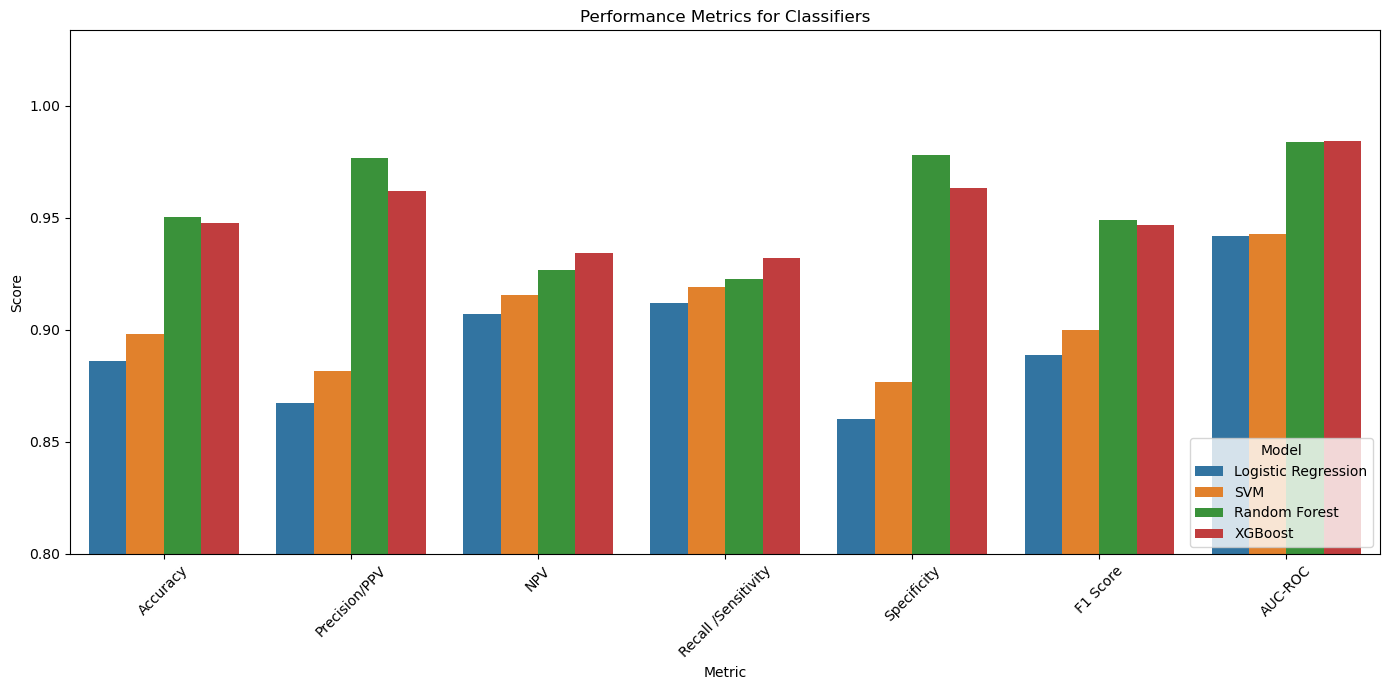

In [57]:
plt.figure(figsize=(14, 7))
sns.barplot(
    data=results_df,
    x="Metric",
    y="Score",
    hue="Model",
    ci=None,
    capsize=0.1
)

plt.title('Performance Metrics for Classifiers')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0.8, None)
plt.legend(title='Model', loc='lower right', bbox_to_anchor=(1, 0))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('performance_survival_oversamp.png', dpi=900)
plt.show()

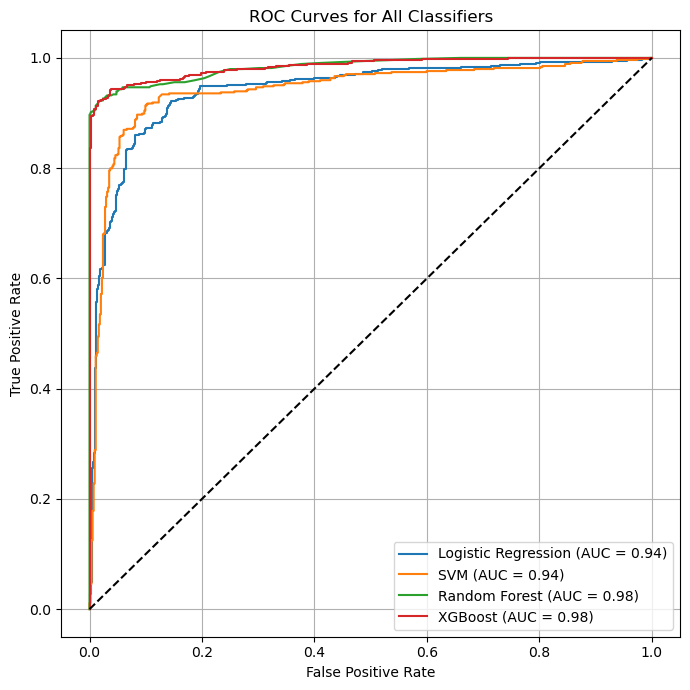

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

for clf_name, clf in classifiers.items():
    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X1_test)[:, 1]
    else:
        y_score = clf.decision_function(X1_test)
        
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC Curves for All Classifiers')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_survival_oversamp.png', dpi=900)
plt.show()

In [59]:
explainer = shap.TreeExplainer(clfxgb)
explanation = explainer(X1_test)
shap_values = explainer.shap_values(X1_test)

In [60]:
plt.figure() 

shap.summary_plot(shap_values, X1_test, show=False)

plt.savefig('shap_beeswarm_survival_oversamp.png', dpi=900, bbox_inches='tight')

plt.close()

In [61]:
plt.figure() 

shap.summary_plot(shap_values, X1_test, plot_type="bar", show=False)

plt.savefig('shap_bar_survival_oversamp.png', dpi=900, bbox_inches='tight')

plt.close()

In [63]:
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
shap_value_list = mean_abs_shap_values.tolist()
shap_values_df = pd.Series(mean_abs_shap_values, index=X1_test.columns).sort_values(ascending=False)
print(shap_values_df)

pulse                                   1.860816
age                                     1.191325
gcs_evm                                 1.145440
rotterdam_ct_grade                      0.927432
time_to_first_doctor                    0.561964
time_in_trauma_center                   0.432878
intracranial_hem_vol                    0.390841
speech                                  0.369599
left_eye_vision                         0.342773
right_eye_vision                        0.324642
vomiting                                0.301080
respiration                             0.252332
head_injury_type                        0.181350
mechanism_of_injury                     0.158093
power_lul                               0.148497
sex                                     0.123758
power_lll                               0.114400
csf_rhinorrhea                          0.090632
headache                                0.086225
power_rll                               0.075600
xray_abnormality    

In [64]:
shap_values_csv_path = 'shap_survival_oversamp.csv'
shap_values_df.to_csv(shap_values_csv_path, header=True)

print(f"SHAP values saved to: {shap_values_csv_path}")

SHAP values saved to: shap_survival_oversamp.csv


In [65]:
max_score = 10
shap_values_normalized = shap_values_df / shap_values_df.max() * max_score

shap_scores = shap_values_normalized.round().astype(int)

print("Feature Weights (Whole Numbers):")
print(shap_scores)

Feature Weights (Whole Numbers):
pulse                                   10
age                                      6
gcs_evm                                  6
rotterdam_ct_grade                       5
time_to_first_doctor                     3
time_in_trauma_center                    2
intracranial_hem_vol                     2
speech                                   2
left_eye_vision                          2
right_eye_vision                         2
vomiting                                 2
respiration                              1
head_injury_type                         1
mechanism_of_injury                      1
power_lul                                1
sex                                      1
power_lll                                1
csf_rhinorrhea                           0
headache                                 0
power_rll                                0
xray_abnormality                         0
associated_injury                        0
power_rul            

TBI Risk Score (Unscaled Variables from X_resampled):
      TBI_Risk_Score
0        1057.094892
1        1126.129922
2        1165.977343
3        1110.855483
4        1341.689147
...              ...
3620     1164.520761
3621     1092.996541
3622     1069.396782
3623     1018.531157
3624      949.313874

[3625 rows x 1 columns]

X_resampled with TBI Risk Score and Risk Categories:
      TBI_Risk_Score Risk_Category
0        1057.094892     High Risk
1        1126.129922     High Risk
2        1165.977343     High Risk
3        1110.855483     High Risk
4        1341.689147     High Risk
...              ...           ...
3620     1164.520761     High Risk
3621     1092.996541     High Risk
3622     1069.396782     High Risk
3623     1018.531157     High Risk
3624      949.313874     High Risk

[3625 rows x 2 columns]


/Users/suhrudp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


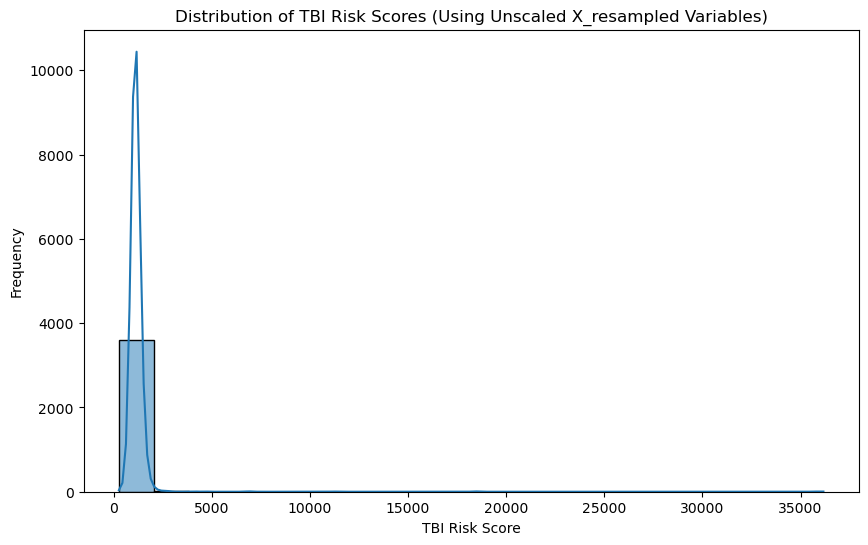


TBI Risk Scoring Formula:
TBI Risk Score = (10 * pulse) + (6 * age) + (6 * gcs_evm) + (5 * rotterdam_ct_grade) + (3 * time_to_first_doctor) + (2 * time_in_trauma_center) + (2 * intracranial_hem_vol) + (2 * speech) + (2 * left_eye_vision) + (2 * right_eye_vision) + (2 * vomiting) + (1 * respiration) + (1 * head_injury_type) + (1 * mechanism_of_injury) + (1 * power_lul) + (1 * sex) + (1 * power_lll) + (0 * csf_rhinorrhea) + (0 * headache) + (0 * power_rll) + (0 * xray_abnormality) + (0 * associated_injury) + (0 * power_rul) + (0 * amnesia) + (0 * seizures) + (0 * left_eye_nasal_loss) + (0 * speech_past_history) + (0 * alcohol_consumption) + (0 * right_eye_nasal_loss) + (0 * right_eye_temporal_loss) + (0 * vision_past_history) + (0 * left_eye_temporal_loss) + (0 * pre_existing_neurological_deficiency)


In [66]:
def calculate_tbi_risk_score(row, shap_scores):
    score = 0
    for feature in shap_scores.index:
        score += shap_scores[feature] * row[feature]
    return score

X_resampled['TBI_Risk_Score'] = X_resampled.apply(lambda row: calculate_tbi_risk_score(row, shap_scores), axis=1)

print("TBI Risk Score (Unscaled Variables from X_resampled):")
print(X_resampled[['TBI_Risk_Score']])

low_risk_threshold = 33  
high_risk_threshold = 67  

X_resampled['Risk_Category'] = pd.cut(
    X_resampled['TBI_Risk_Score'], 
    bins=[-np.inf, low_risk_threshold, high_risk_threshold, np.inf], 
    labels=['Low Risk', 'Moderate Risk', 'High Risk']
)

print("\nX_resampled with TBI Risk Score and Risk Categories:")
print(X_resampled[['TBI_Risk_Score', 'Risk_Category']])

plt.figure(figsize=(10, 6))
sns.histplot(X_resampled['TBI_Risk_Score'], kde=True, bins=20)
plt.title('Distribution of TBI Risk Scores (Using Unscaled X_resampled Variables)')
plt.xlabel('TBI Risk Score')
plt.ylabel('Frequency')
plt.show()

formula_terms = [f"({weight} * {feature})" for feature, weight in shap_scores.items()]
tbi_risk_formula = "TBI Risk Score = " + " + ".join(formula_terms)

print("\nTBI Risk Scoring Formula:")
print(tbi_risk_formula)

Normalized Feature Weights (Scaled to ensure any potential score <= 100):
pulse                                   0.021179
age                                     0.012707
gcs_evm                                 0.012707
rotterdam_ct_grade                      0.010589
time_to_first_doctor                    0.006354
time_in_trauma_center                   0.004236
intracranial_hem_vol                    0.004236
speech                                  0.004236
left_eye_vision                         0.004236
right_eye_vision                        0.004236
vomiting                                0.004236
respiration                             0.002118
head_injury_type                        0.002118
mechanism_of_injury                     0.002118
power_lul                               0.002118
sex                                     0.002118
power_lll                               0.002118
csf_rhinorrhea                          0.000000
headache                                0.00

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


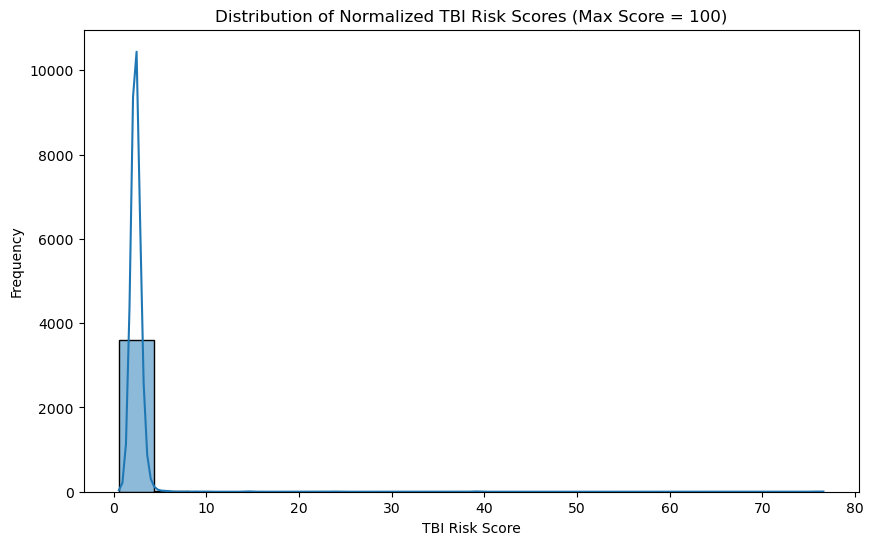


Normalized TBI Risk Scoring Formula (Max Score = 100):
TBI Risk Score = (0.02 * pulse) + (0.01 * age) + (0.01 * gcs_evm) + (0.01 * rotterdam_ct_grade) + (0.01 * time_to_first_doctor) + (0.00 * time_in_trauma_center) + (0.00 * intracranial_hem_vol) + (0.00 * speech) + (0.00 * left_eye_vision) + (0.00 * right_eye_vision) + (0.00 * vomiting) + (0.00 * respiration) + (0.00 * head_injury_type) + (0.00 * mechanism_of_injury) + (0.00 * power_lul) + (0.00 * sex) + (0.00 * power_lll) + (0.00 * csf_rhinorrhea) + (0.00 * headache) + (0.00 * power_rll) + (0.00 * xray_abnormality) + (0.00 * associated_injury) + (0.00 * power_rul) + (0.00 * amnesia) + (0.00 * seizures) + (0.00 * left_eye_nasal_loss) + (0.00 * speech_past_history) + (0.00 * alcohol_consumption) + (0.00 * right_eye_nasal_loss) + (0.00 * right_eye_temporal_loss) + (0.00 * vision_past_history) + (0.00 * left_eye_temporal_loss) + (0.00 * pre_existing_neurological_deficiency)


In [67]:
max_feature_values = {
    'mechanism_of_injury': max(encoding_mappings['mechanism_of_injury'].values()),
    'respiration': max(encoding_mappings['respiration'].values()),
    'xray_abnormality': max(encoding_mappings['xray_abnormality'].values()),
    'right_eye_vision': max(encoding_mappings['right_eye_vision'].values()),
    'left_eye_vision': max(encoding_mappings['left_eye_vision'].values()),
    'associated_injury': max(encoding_mappings['associated_injury'].values()),
    'speech': max(encoding_mappings['speech'].values()),
    'sex': max(encoding_mappings['sex'].values()),
    'headache': max(encoding_mappings['headache'].values()),
    'seizures': max(encoding_mappings['seizures'].values()),
    'vomiting': max(encoding_mappings['vomiting'].values()),
    'amnesia': max(encoding_mappings['amnesia'].values()),
    'csf_rhinorrhea': max(encoding_mappings['csf_rhinorrhea'].values()),
    'alcohol_consumption': max(encoding_mappings['alcohol_consumption'].values()),
    'speech_past_history': max(encoding_mappings['speech_past_history'].values()),
    'pre_existing_neurological_deficiency': max(encoding_mappings['pre_existing_neurological_deficiency'].values()),
    'head_injury_type': max(encoding_mappings['head_injury_type'].values()),
    'right_eye_temporal_loss': max(encoding_mappings['right_eye_temporal_loss'].values()),
    'right_eye_nasal_loss': max(encoding_mappings['right_eye_nasal_loss'].values()),
    'left_eye_temporal_loss': max(encoding_mappings['left_eye_temporal_loss'].values()),
    'left_eye_nasal_loss': max(encoding_mappings['left_eye_nasal_loss'].values()),
    'vision_past_history': max(encoding_mappings['vision_past_history'].values()),
    'power_rul': max(encoding_mappings['power_rul'].values()),
    'power_rll': max(encoding_mappings['power_rll'].values()),
    'power_lul': max(encoding_mappings['power_lul'].values()),
    'power_lll': max(encoding_mappings['power_lll'].values())
}

continuous_features = ['gcs_evm', 'rotterdam_ct_grade', 'age', 'intracranial_hem_vol', 
                       'pulse', 'time_in_trauma_center', 'time_to_first_doctor']
for feature in continuous_features:
    max_feature_values[feature] = X_resampled[feature].max()

max_theoretical_score = sum(shap_scores[feature] * max_feature_values[feature] for feature in shap_scores.index)


scaling_factor = 100 / max_theoretical_score
normalized_shap_scores = shap_scores * scaling_factor

# Display the normalized weights
print("Normalized Feature Weights (Scaled to ensure any potential score <= 100):")
print(normalized_shap_scores)

def calculate_normalized_tbi_risk_score(row, normalized_shap_scores):
    score = 0
    for feature in normalized_shap_scores.index:
        score += normalized_shap_scores[feature] * row[feature]
    return score

X_resampled['TBI_Risk_Score'] = X_resampled.apply(lambda row: calculate_normalized_tbi_risk_score(row, normalized_shap_scores), axis=1)


low_risk_threshold = 33
high_risk_threshold = 67

X_resampled['Risk_Category'] = pd.cut(
    X_resampled['TBI_Risk_Score'], 
    bins=[-np.inf, low_risk_threshold, high_risk_threshold, np.inf], 
    labels=['Low Risk', 'Moderate Risk', 'High Risk']
)

print("\nX_resampled with Normalized TBI Risk Score and Risk Categories:")
print(X_resampled[['TBI_Risk_Score', 'Risk_Category']])

plt.figure(figsize=(10, 6))
sns.histplot(X_resampled['TBI_Risk_Score'], kde=True, bins=20)
plt.title('Distribution of Normalized TBI Risk Scores (Max Score = 100)')
plt.xlabel('TBI Risk Score')
plt.ylabel('Frequency')
plt.show()

formula_terms = [f"({weight:.2f} * {feature})" for feature, weight in normalized_shap_scores.items()]
tbi_risk_formula = "TBI Risk Score = " + " + ".join(formula_terms)

print("\nNormalized TBI Risk Scoring Formula (Max Score = 100):")
print(tbi_risk_formula)

Normalized Feature Weights (Scaled to ensure any potential score <= 100 and multiplied by 10):
pulse                                   0.211788
age                                     0.127073
gcs_evm                                 0.127073
rotterdam_ct_grade                      0.105894
time_to_first_doctor                    0.063536
time_in_trauma_center                   0.042358
intracranial_hem_vol                    0.042358
speech                                  0.042358
left_eye_vision                         0.042358
right_eye_vision                        0.042358
vomiting                                0.042358
respiration                             0.021179
head_injury_type                        0.021179
mechanism_of_injury                     0.021179
power_lul                               0.021179
sex                                     0.021179
power_lll                               0.021179
csf_rhinorrhea                          0.000000
headache               

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


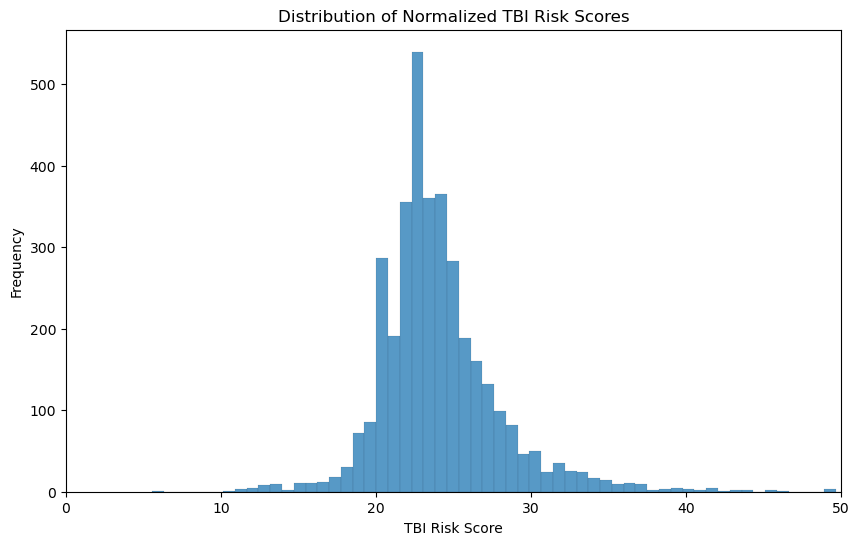


Normalized TBI Risk Scoring Formula):
TBI Risk Score = (0.21 * pulse) + (0.13 * age) + (0.13 * gcs_evm) + (0.11 * rotterdam_ct_grade) + (0.06 * time_to_first_doctor) + (0.04 * time_in_trauma_center) + (0.04 * intracranial_hem_vol) + (0.04 * speech) + (0.04 * left_eye_vision) + (0.04 * right_eye_vision) + (0.04 * vomiting) + (0.02 * respiration) + (0.02 * head_injury_type) + (0.02 * mechanism_of_injury) + (0.02 * power_lul) + (0.02 * sex) + (0.02 * power_lll) + (0.00 * csf_rhinorrhea) + (0.00 * headache) + (0.00 * power_rll) + (0.00 * xray_abnormality) + (0.00 * associated_injury) + (0.00 * power_rul) + (0.00 * amnesia) + (0.00 * seizures) + (0.00 * left_eye_nasal_loss) + (0.00 * speech_past_history) + (0.00 * alcohol_consumption) + (0.00 * right_eye_nasal_loss) + (0.00 * right_eye_temporal_loss) + (0.00 * vision_past_history) + (0.00 * left_eye_temporal_loss) + (0.00 * pre_existing_neurological_deficiency)


In [68]:

max_feature_values = {
    'mechanism_of_injury': max(encoding_mappings['mechanism_of_injury'].values()),
    'respiration': max(encoding_mappings['respiration'].values()),
    'xray_abnormality': max(encoding_mappings['xray_abnormality'].values()),
    'right_eye_vision': max(encoding_mappings['right_eye_vision'].values()),
    'left_eye_vision': max(encoding_mappings['left_eye_vision'].values()),
    'associated_injury': max(encoding_mappings['associated_injury'].values()),
    'speech': max(encoding_mappings['speech'].values()),
    'sex': max(encoding_mappings['sex'].values()),
    'headache': max(encoding_mappings['headache'].values()),
    'seizures': max(encoding_mappings['seizures'].values()),
    'vomiting': max(encoding_mappings['vomiting'].values()),
    'amnesia': max(encoding_mappings['amnesia'].values()),
    'csf_rhinorrhea': max(encoding_mappings['csf_rhinorrhea'].values()),
    'alcohol_consumption': max(encoding_mappings['alcohol_consumption'].values()),
    'speech_past_history': max(encoding_mappings['speech_past_history'].values()),
    'pre_existing_neurological_deficiency': max(encoding_mappings['pre_existing_neurological_deficiency'].values()),
    'head_injury_type': max(encoding_mappings['head_injury_type'].values()),
    'right_eye_temporal_loss': max(encoding_mappings['right_eye_temporal_loss'].values()),
    'right_eye_nasal_loss': max(encoding_mappings['right_eye_nasal_loss'].values()),
    'left_eye_temporal_loss': max(encoding_mappings['left_eye_temporal_loss'].values()),
    'left_eye_nasal_loss': max(encoding_mappings['left_eye_nasal_loss'].values()),
    'vision_past_history': max(encoding_mappings['vision_past_history'].values()),
    'power_rul': max(encoding_mappings['power_rul'].values()),
    'power_rll': max(encoding_mappings['power_rll'].values()),
    'power_lul': max(encoding_mappings['power_lul'].values()),
    'power_lll': max(encoding_mappings['power_lll'].values())
}


continuous_features = ['gcs_evm', 'rotterdam_ct_grade', 'age', 'intracranial_hem_vol', 
                       'pulse', 'time_in_trauma_center', 'time_to_first_doctor']
for feature in continuous_features:
    max_feature_values[feature] = X_resampled[feature].max()


max_theoretical_score = sum(shap_scores[feature] * max_feature_values[feature] for feature in shap_scores.index)


scaling_factor = 100 / max_theoretical_score
normalized_shap_scores = shap_scores * scaling_factor * 10  



print("Normalized Feature Weights (Scaled to ensure any potential score <= 100 and multiplied by 10):")
print(normalized_shap_scores)


def calculate_normalized_tbi_risk_score(row, normalized_shap_scores):
    score = 0
    for feature in normalized_shap_scores.index:
        score += normalized_shap_scores[feature] * row[feature]
    return score


X_resampled['TBI_Risk_Score'] = X_resampled.apply(lambda row: calculate_normalized_tbi_risk_score(row, normalized_shap_scores), axis=1)


low_risk_threshold = 33
high_risk_threshold = 67

X_resampled['Risk_Category'] = pd.cut(
    X_resampled['TBI_Risk_Score'], 
    bins=[-np.inf, low_risk_threshold, high_risk_threshold, np.inf], 
    labels=['Low Risk', 'Moderate Risk', 'High Risk']
)


print("\nX_resampled with Normalized TBI Risk Score and Risk Categories:")
print(X_resampled[['TBI_Risk_Score', 'Risk_Category']])


plt.figure(figsize=(10, 6))
sns.histplot(X_resampled['TBI_Risk_Score'], kde=False, bins=1000)
plt.title('Distribution of Normalized TBI Risk Scores')
plt.xlabel('TBI Risk Score')
plt.ylabel('Frequency')
plt.xlim(0, 50)
plt.savefig('normalized_scores_survival_oversamp.png', dpi=900)
plt.show()


formula_terms = [f"({weight:.2f} * {feature})" for feature, weight in normalized_shap_scores.items()]
tbi_risk_formula = "TBI Risk Score = " + " + ".join(formula_terms)

print("\nNormalized TBI Risk Scoring Formula):")
print(tbi_risk_formula)

In [69]:
import pandas as pd


formula_df = pd.DataFrame({
    'Feature': normalized_shap_scores.index,
    'Weight': normalized_shap_scores.values
})


formula_df['Formula Component'] = formula_df.apply(lambda row: f"({row['Weight']:.2f} * {row['Feature']})", axis=1)


tbi_risk_formula = "TBI Risk Score = " + " + ".join(formula_df['Formula Component'])


formula_csv_path = 'formula_survival_oversamp.csv'
formula_df.to_csv(formula_csv_path, index=False)

print(f"Formula saved to: {formula_csv_path}")

Formula saved to: formula_survival_oversamp.csv


Approximate Unscaled Threshold for class 1 vs Rest: 21.76
Skipping ROC calculation for class 3, only one class present.


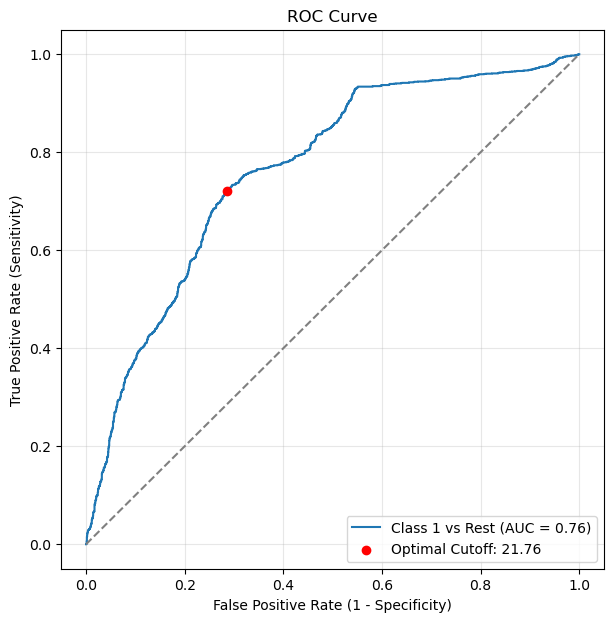

In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


for column, mapping in all_mappings.items():
    if column in X_resampled.columns:
        X_resampled[column] = X_resampled[column].map(mapping).fillna(-1)


if not np.issubdtype(X_resampled.dtypes.values.any(), np.number):
    raise ValueError("Some columns still contain non-numeric data.")


scaler = RobustScaler()


X_resampled_scaled = pd.DataFrame(
    scaler.fit_transform(X_resampled), 
    columns=X_resampled.columns, 
    index=X_resampled.index
)


plt.figure(figsize=(7,7))
for class_label in [1, 3]: 
    y_binary = (y_encoded == class_label).astype(int)  


    if len(np.unique(y_binary)) < 2:
        print(f"Skipping ROC calculation for class {class_label}, only one class present.")
        continue


    df_score_scaled = X_resampled_scaled.copy()
    df_score_scaled['TBI_Risk_Score'] = df_score_scaled.apply(
        lambda row: calculate_normalized_tbi_risk_score(row, normalized_shap_scores), axis=1
    )
    
    
    y_scores = -df_score_scaled['TBI_Risk_Score']
    
    
    fpr, tpr, thresholds = roc_curve(y_binary, y_scores)
    roc_auc = roc_auc_score(y_binary, y_scores)
    
    
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold_scaled = thresholds[optimal_idx]
    
    
    unscaled_score = 0
    for feature in normalized_shap_scores.index:
        scaled_contribution = (
            optimal_threshold_scaled * normalized_shap_scores[feature] / normalized_shap_scores.sum()
        )
        
        feature_array = np.zeros((1, X_resampled_scaled.shape[1]))
        feature_index = X_resampled_scaled.columns.get_loc(feature)
        feature_array[0, feature_index] = scaled_contribution
        
        unscaled_feature_value = scaler.inverse_transform(feature_array)[0, feature_index]
        unscaled_score += unscaled_feature_value * normalized_shap_scores[feature]
    
    print(f"Approximate Unscaled Threshold for class {class_label} vs Rest: {unscaled_score:.2f}")
    
    
    plt.plot(fpr, tpr, label=f'Class {class_label} vs Rest (AUC = {roc_auc:.2f})')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], c='red', 
                label=f'Optimal Cutoff: {unscaled_score:.2f}', zorder=5)


plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('roc_tbi_score_survival_oversamp.png', dpi=900)
plt.show()